In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)
data = pd.read_sql_query('SELECT * FROM loan', engine)
data.head()

,loan_id,account_id,date,amount,duration,payments,status,status_desc
0,5314,1787,930705,96396,12,8033.0,B,Defaulter - Contract Finished
1,5316,1801,930711,165960,36,4610.0,A,Good - Contract Finished
2,6863,9188,930728,127080,60,2118.0,A,Good - Contract Finished
3,5325,1843,930803,105804,36,2939.0,A,Good - Contract Finished
4,7240,11013,930906,274740,60,4579.0,A,Good - Contract Finished


In [3]:
query = '''select * from trans t
left join loan l
on t.account_id = l.account_id
where l.status in ('A', 'B');'''

data = pd.read_sql_query(query, engine)
data.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account,loan_id,account_id,date,amount,duration,payments,status,status_desc
0,1548750,5270,930114,PRIJEM,PREVOD Z UCTU,44749.0,45549.0,,IJ,80269753,6077,5270,931122,79608,24,3317.0,A,Good - Contract Finished
1,3393738,11265,930114,PRIJEM,VKLAD,1000.0,1000.0,,,0,7284,11265,930915,52788,12,4399.0,A,Good - Contract Finished
2,3122924,10364,930117,PRIJEM,VKLAD,1100.0,1100.0,,,0,7121,10364,931110,21924,36,609.0,A,Good - Contract Finished
3,1121963,3834,930119,PRIJEM,VKLAD,700.0,700.0,,,0,5754,3834,940928,23052,12,1921.0,A,Good - Contract Finished
4,2809952,9307,930124,PRIJEM,VKLAD,900.0,900.0,,,0,6895,9307,940919,41904,12,3492.0,A,Good - Contract Finished


In [5]:
#more specific with our fields 

# Extracting the data (the previous query modified)

query = '''select t.type, t.operation, t.amount as t_amount, t.balance, t.k_symbol, l.amount as l_amount, l.duration, l.payments, l.status
from trans t
left join loan l
on t.account_id = l.account_id
where l.status in ('A', 'B');'''
data = pd.read_sql_query(query, engine)
data.head()

,type,operation,t_amount,balance,k_symbol,l_amount,duration,payments,status
0,PRIJEM,PREVOD Z UCTU,44749.0,45549.0,,79608,24,3317.0,A
1,PRIJEM,VKLAD,1000.0,1000.0,,52788,12,4399.0,A
2,PRIJEM,VKLAD,1100.0,1100.0,,21924,36,609.0,A
3,PRIJEM,VKLAD,700.0,700.0,,23052,12,1921.0,A
4,PRIJEM,VKLAD,900.0,900.0,,41904,12,3492.0,A


In [6]:
data.shape

(74364, 9)

In [7]:

data.dtypes

type          object
operation     object
t_amount     float64
balance      float64
k_symbol      object
l_amount       int64
duration       int64
payments     float64
status        object
dtype: object

In [9]:
data['duration'] = data['duration'].astype('object') # This will be treated as categorical
data.describe()

,t_amount,balance,l_amount,payments
count,74364.000000,74364.000000,74364.000000,74364.000000
mean,7832.649125,46022.153061,102745.132645,4356.580832
std,11729.040391,25439.948570,74749.275498,2205.840892
min,0.000000,-14137.200000,4980.000000,319.000000
25%,144.300000,27675.125000,46320.000000,2569.000000
50%,3000.000000,40965.150000,86184.000000,4051.000000
75%,9868.500000,60098.550000,140400.000000,6315.000000
max,87300.000000,193910.000000,464520.000000,9736.000000


In [10]:
data.isna().sum()

type         0
operation    0
t_amount     0
balance      0
k_symbol     0
l_amount     0
duration     0
payments     0
status       0
dtype: int64

In [12]:
## checking all the categorical columns
data['operation'].value_counts()


VYBER             34667
                  14646
PREVOD NA UCET    11647
VKLAD             10525
PREVOD Z UCTU      2489
VYBER KARTOU        390
Name: operation, dtype: int64

In [13]:
data['operation'].value_counts()
def cleanOperation(x):
    x = x.lower()
    if 'vyber' in x:
        return "vyber"
    elif 'prevod' in x:
        return "prevod"
    elif 'vklad' in x:
        return 'vklad'
    else:
        return 'unknown'

data['operation'] = list(map(cleanOperation, data['operation']))

In [14]:
data['k_symbol'].value_counts()

               35953
UROK           14646
SLUZBY         11306
SIPO            5081
                3018
UVER            2893
POJISTNE        1159
SANKC. UROK      308
Name: k_symbol, dtype: int64

In [15]:
data['k_symbol'].value_counts().index

Index(['', 'UROK', 'SLUZBY', 'SIPO', ' ', 'UVER', 'POJISTNE', 'SANKC. UROK'], dtype='object')

In [16]:
def cleankSymbol(x):
    if x in ['', ' ']:
        return 'unknown'
    else:
        return x

data['k_symbol'] = list(map(cleankSymbol, data['k_symbol']))

In [20]:
data = data[~data['k_symbol'].isin(['POJISTINE', 'SANKC. UROK', 'UVER'])]

In [ ]:
data['duration'].value_counts()

In [18]:
data['duration'].value_counts().index

Index(['12', '24', '36', 'other'], dtype='object')

In [17]:
def cleanDuration(x):
    if x in [48, 60]:
        return 'other'
    else:
        return str(x)
data['duration'] = list(map(cleanDuration, data['duration']))
data.head()

,type,operation,t_amount,balance,k_symbol,l_amount,duration,payments,status
0,PRIJEM,prevod,44749.0,45549.0,unknown,79608,24,3317.0,A
1,PRIJEM,vklad,1000.0,1000.0,unknown,52788,12,4399.0,A
2,PRIJEM,vklad,1100.0,1100.0,unknown,21924,36,609.0,A
3,PRIJEM,vklad,700.0,700.0,unknown,23052,12,1921.0,A
4,PRIJEM,vklad,900.0,900.0,unknown,41904,12,3492.0,A


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

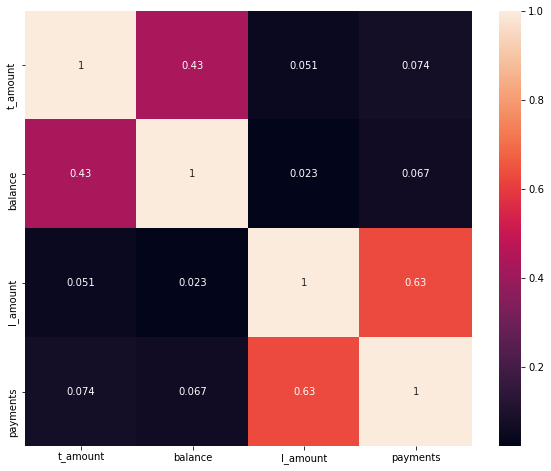

In [21]:
# Checking for multicollinearity

corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

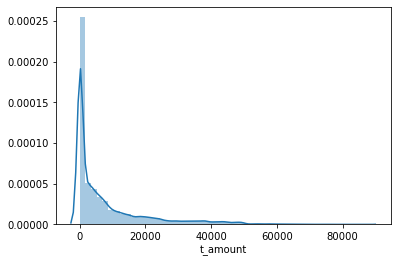

In [22]:
sns.distplot(data['t_amount'])
plt.show()

#sns.distplot(data['l_amount'])
#plt.show()

#sns.distplot(data['balance'])
#plt.show()

#sns.distplot(data['payments'])
#plt.show()

In [23]:
from sklearn.preprocessing import Normalizer
# from sklearn.preprocessing import StandardScaler

In [28]:
import numpy as np 
X = data.select_dtypes(include = np.number)
# Normalizing data
transformer = Normalizer().fit(X)
x_normalized = transformer.transform(X)
x = pd.DataFrame(x_normalized)

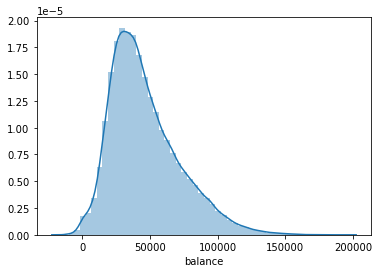

In [29]:
sns.distplot(data['balance'])
plt.show()